# Dear LEGO, what happened?!

I used to love playing with LEGO in the 90s when I was growing up, we built many crazy cool empires with my dad. But now, when I play with my kids, LEGO frustrates me more than anything. Instead of getting creative how to build a simple windmill with many wheels out of the "4er, 8er and some rods and wheels", there are funny bits, non-matching shades and users' manuals everwhere. So let's see what changed over time and how much of this is just old mum complaining. 

The data comes from [rebrickable](https://rebrickable.com/downloads/) and fully up-to-date as of today, 3 May 2024. I was inpired by [tidytuesday](https://github.com/rfordatascience/tidytuesday/blob/master/data/2022/2022-09-06/readme.md) for this data analysis. 

Specifically I will explore: 
1. 




# Imports

In [11]:
import csv
import gzip
import os

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter  # for percentages
import seaborn as sns

%matplotlib inline

In [12]:
# Directory of gzipped files
data_dir = "data/"

# List of gzipped file paths
gz_files = ["colors.csv.gz", "elements.csv.gz", "inventories.csv.gz", "inventory_minifigs.csv.gz", 
            "inventory_parts.csv.gz", "inventory_sets.csv.gz", "part_categories.csv.gz", "part_relationships.csv.gz", 
            "sets.csv.gz", "minifigs.csv.gz", "themes.csv.gz", "parts.csv.gz"]

# Dictionary to store DataFrames
lego_datasets = {}

for file_name in gz_files:
    # construct full file path
    file_path = os.path.join(data_dir, file_name)
    
    data = []

    # Open the gzipped file
    with gzip.open(file_path, "rt") as file:
        reader = csv.reader(file) # CSV header
        columns = next(reader) # for header row
        for row in reader:
           data.append(row)

    # Create a pandas DataFrame
    df_name = file_name.split(".")[0]  # Extract filename without extension
    lego_datasets[df_name] = pd.DataFrame(data, columns = columns)


The datasets are related to each other and contain the following variables: ![](schema_v3.webp)



I am expecially interested in the aging of trends, so I'll use the _year_ variable of the _sets_ dataset first. There are actually 75 years with data (1949-2025). 

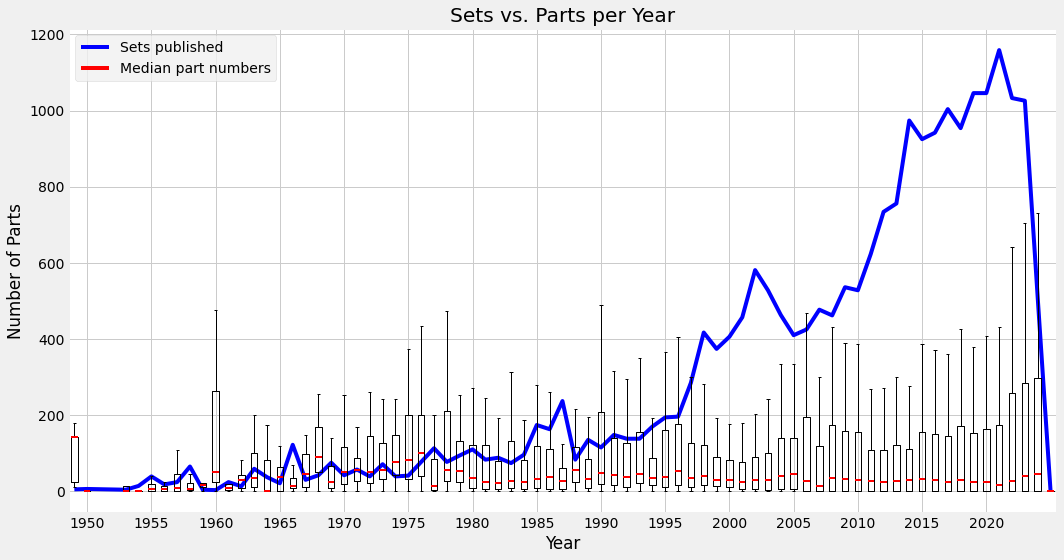

In [24]:
import numpy as np
import matplotlib.pyplot as plt

sets = lego_datasets["sets"]

# Set plot
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 8))

# Plot 1 - Line plot
sets_num_agg = sets[['year', 'set_num']].groupby(['year']).agg('count')
sets_num_agg.index = sets_num_agg.index.astype(int)

year = sets_num_agg.index.values
set_number = sets_num_agg['set_num'].values

plt.plot(year, set_number, color='blue', label='Set numbers published')

# Plot 2 - Boxplot
parts_year = sets[['year', 'num_parts']].astype('int')
parts_year = parts_year[['year', 'num_parts']]

years = np.arange(min(parts_year['year']) + 1, max(parts_year['year']) - 4, 5)

bp = plt.boxplot([group['num_parts'] for year, group in parts_year.groupby('year')],
                 positions=sorted(parts_year['year'].unique()), showfliers=False,
                 medianprops=dict(color='red', linewidth=2))

plt.title('Sets vs. Parts per Year')
plt.xlabel('Year')
plt.ylabel('Number of Parts')
plt.xticks(years, years)
plt.grid(True)
plt.gca().set_facecolor('white') 

# Create legend manually for both plots
line_legend = plt.Line2D([], [], color='blue', label='Sets published')
boxplot_legend = plt.Line2D([], [], color='red', marker='_', markersize=10, label='Median part numbers')

# Combine legends
plt.legend(handles=[line_legend, boxplot_legend])

# Display settings
plt.tight_layout()
plt.show()

Altough there are more sets being published every year, the sets do not increase in size (although the number of parts per set seems to vary more recently than before). Note, that this doesn't tell us about the specificity of parts per set: if a set has set-specific parts, it will increase the overall complexity of "all lego parts in a household". 

## Most common LEGO themes


Out of interest I wanted to see which are the most popular themes for Lego sets. 

In [25]:
themes = lego_datasets["themes"]

# merge DFs to get parent theme
themes_common = sets.merge(themes, left_on = 'theme_id', right_on = 'id', how = 'left')
themes_common.rename(columns = {'name_y': 'theme_parent', 'name_x': 'theme_child'}, 
                     inplace = True)

# get count data for plot
themes_common_count = themes_common.groupby('theme_parent').size().reset_index(name='count').set_index('theme_parent')

# visualise onyl the top 10% (from 388 themes)
threshold_count = int(len(themes_common_count) * 0.1)
themes_common_count = themes_common_count.sort_values(by = 'count', ascending = False)
themes_common_count_top10 = themes_common_count.head(threshold_count)

# Sort the top 10% themes by theme_count in ascending order
themes_common_count_top10 = themes_common_count_top10.sort_values(by='count', ascending=True)

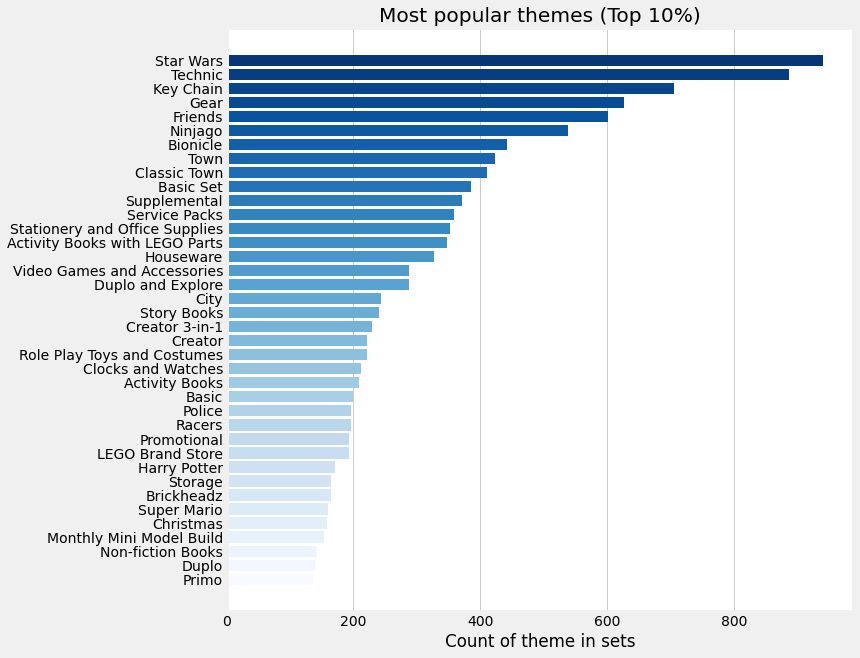

In [26]:
theme_parent = themes_common_count_top10.index.values
count = themes_common_count_top10['count'].values

cmap = mpl.colormaps['Blues']

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))

plt.barh(theme_parent, count, color=[cmap(i/len(theme_parent)) for i in range(len(theme_parent))])

plt.gca().set_facecolor('white')
plt.grid(axis = 'y', which = 'major')

plt.title("Most popular themes (Top 10%)")
plt.xlabel("Count of theme in sets")
plt.show()

## Color composition over time 
This great idea for visualisation came from [David Robinson](https://www.youtube.com/watch?v=CTWkJrvfRBc) at Tidy Tuesday (written in R). 

In [34]:
sets_colors = lego_datasets['sets']\
                .merge(lego_datasets['inventories'], on='set_num', how = 'left')\
                .merge(lego_datasets['inventory_parts'], left_on = 'id', right_on = 'inventory_id', how = 'left')\
                .merge(lego_datasets['colors'], left_on = 'color_id', right_on = 'id', how = 'left')
sets_colors = sets_colors[['year', 'name_y', 'rgb']].rename(columns = {'name_y':'color'}).set_index('year')
sets_colors['rgb'] = '#' + sets_colors['rgb']
sets_colors

,color,rgb
year,,
2022,Flat Silver,#898788
1965,Light Gray,#9BA19D
1965,White,#FFFFFF
1965,White,#FFFFFF
1965,White,#FFFFFF
...,...,...
2013,Dark Bluish Gray,#6C6E68
2013,Dark Bluish Gray,#6C6E68
2013,Dark Tan,#958A73


In [36]:
sets_colors_count = sets_colors.groupby('year').agg('count')
sets_colors_count

,color,rgb
year,,
1949,171,171
1950,22,22
1953,26,26
1954,109,109
1955,265,265
...,...,...
2021,81697,81697
2022,77174,77174
2023,88198,88198


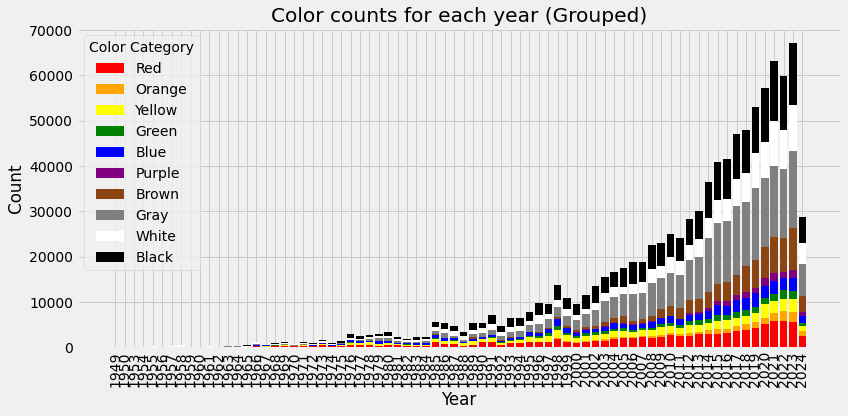

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Remove rows with NaN values
# sets_colors_cleaned = sets_colors.dropna()

# Define color categories manually
color_categories = {
    'Red': ['Red', 'Dark Red', 'Light Red', 'Coral'],
    'Orange': ['Orange', 'Dark Orange', 'Light Orange'],
    'Yellow': ['Yellow', 'Dark Yellow', 'Light Yellow', 'Light Nougat'],
    'Green': ['Green', 'Dark Green', 'Light Green'],
    'Blue': ['Blue', 'Dark Blue', 'Light Blue'],
    'Purple': ['Purple', 'Dark Purple', 'Magenta', 'Dark Pink', 'Medium Lavender'],
    'Brown': ['Brown', 'Dark Brown', 'Tan', 'Reddish Brown'],
    'Gray': ['Gray', 'Dark Gray', 'Light Gray', 'Dark Bluish Gray', 'Medium Stone Gray', 'Light Bluish Gray'],
    'White': ['White'],
    'Black': ['Black']
}

# Map each color to a color category
def map_color_to_category(color):
    for category, colors in color_categories.items():
        if color in colors:
            return category
    return 'Other'

# Apply the mapping function to the color data
sets_colors['color_category'] = sets_colors['color'].apply(map_color_to_category)

# Group by year and color category, and count occurrences
color_counts = sets_colors_cleaned.groupby(['year', 'color_category']).size().unstack(fill_value=0)

# Define color list for the categories
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'saddlebrown', 'gray', 'white', 'black']

# Plot a stacked bar plot
plt.figure(figsize=(12, 6))
bottom = None  # Initialize bottom position
for i, color_category in enumerate(color_categories):
    plt.bar(color_counts.index, color_counts[color_category], bottom=bottom, label=color_category, color=colors[i])
    if bottom is None:
        bottom = color_counts[color_category]
    else:
        bottom += color_counts[color_category]
plt.title('Color counts for each year (Grouped)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Color Category')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


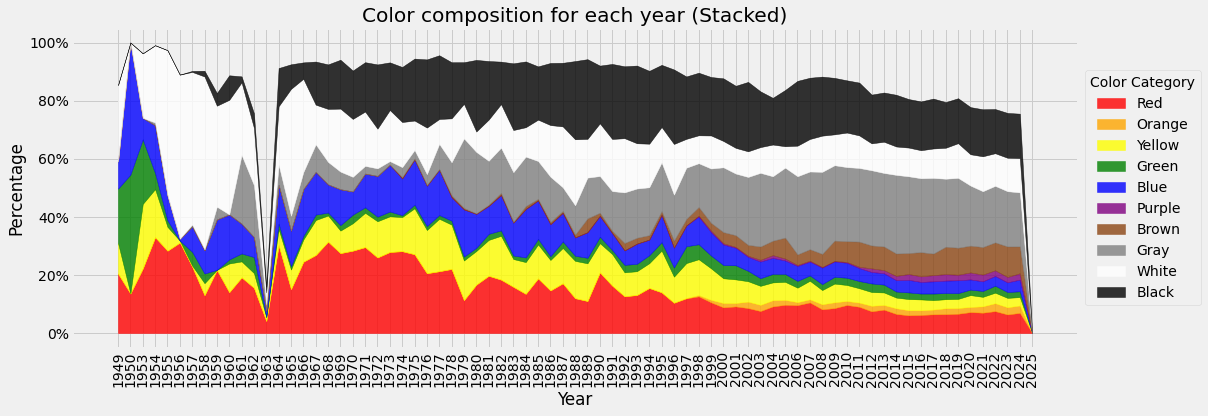

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Define color categories manually
color_categories = {
    'Red': ['Red', 'Dark Red', 'Light Red', 'Coral'],
    'Orange': ['Orange', 'Dark Orange', 'Light Orange'],
    'Yellow': ['Yellow', 'Dark Yellow', 'Light Yellow', 'Light Nougat'],
    'Green': ['Green', 'Dark Green', 'Light Green'],
    'Blue': ['Blue', 'Dark Blue', 'Light Blue'],
    'Purple': ['Purple', 'Dark Purple', 'Magenta', 'Dark Pink', 'Medium Lavender'],
    'Brown': ['Brown', 'Dark Brown', 'Tan', 'Reddish Brown'],
    'Gray': ['Gray', 'Dark Gray', 'Light Gray', 'Dark Bluish Gray', 'Medium Stone Gray', 'Light Bluish Gray'],
    'White': ['White'],
    'Black': ['Black']
}

# Map each color to a color category
def map_color_to_category(color):
    for category, colors in color_categories.items():
        if color in colors:
            return category
    return 'Other'

# Apply the mapping function to the color data
sets_colors['color_category'] = sets_colors['color'].apply(map_color_to_category)

# Group by year and color category, and count occurrences
color_counts = sets_colors.groupby(['year', 'color_category']).size().unstack(fill_value=0)

# Normalize the counts for each year to sum up to 1
color_counts_normalized = color_counts.div(color_counts.sum(axis=1), axis=0)

# Define color list for the categories
colors = {'Red': 'red', 'Orange': 'orange', 'Yellow': 'yellow', 'Green': 'green', 
          'Blue': 'blue', 'Purple': 'purple', 'Brown': 'saddlebrown', 
          'Gray': 'gray', 'White': 'white', 'Black': 'black'}

# Plot a stacked plot
plt.figure(figsize=(17, 6))
years = color_counts_normalized.index
bottom = pd.Series(data=[0] * len(years), index=years)
for color_category in color_categories:
    counts = color_counts_normalized[color_category]
    plt.fill_between(years, bottom, bottom + counts, label=color_category, color=colors[color_category], alpha=0.8)
    bottom = bottom.add(counts, fill_value=0)  # Using add with fill_value=0 to avoid SettingWithCopyWarning
plt.title('Color composition for each year (Stacked) for main colors only')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.legend(title='Color Category', loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))  # Format y-axis ticks as percentages
plt.tight_layout()
plt.show()


In [85]:
sets_colors

,color,rgb,color_category
year,,,
2022,Flat Silver,#898788,Other
1965,Light Gray,#9BA19D,Gray
1965,White,#FFFFFF,White
1965,White,#FFFFFF,White
1965,White,#FFFFFF,White
...,...,...,...
2013,Dark Bluish Gray,#6C6E68,Gray
2013,Dark Bluish Gray,#6C6E68,Gray
2013,Dark Tan,#958A73,Other


In [93]:
sets_colors['color'].unique()

array(['Flat Silver', 'Light Gray', 'White', 'Red', 'Yellow', 'Blue', nan,
       'Black', 'Light Bluish Gray', 'Trans-Red', 'Trans-Clear', 'Green',
       'Tan', 'Dark Green', 'Sand Green', 'Dark Tan', 'Reddish Brown',
       'Dark Red', 'Bright Green', 'Bright Light Yellow', 'Milky White',
       'Dark Bluish Gray', 'Pearl Gold', 'Trans-Yellow', 'Bright Pink',
       'Trans-Light Blue', 'Trans-Brown', 'Trans-Orange', 'Trans-Green',
       'Brown', 'Fabuland Brown', 'Nougat', 'Fabuland Red',
       'Trans-Dark Blue', 'Lime', 'Trans-Bright Green',
       'Pearl Light Gray', 'Trans-Dark Pink', 'Trans-Neon Green',
       'Dark Blue', 'Trans-Neon Orange', 'Dark Brown',
       'Speckle Black-Silver', 'Dark Purple', 'Dark Gray',
       '[No Color/Any Color]', 'Sand Red', 'Chrome Silver', 'Orange',
       'Chrome Gold', 'Dark Pink', 'Trans-Pink', 'Clikits Yellow',
       'Trans-Neon Yellow', 'Trans-Flame Yellowish Orange',
       'Bright Light Orange', 'Sky Blue', 'Trans-Medium Purple',
    